In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import xarray.ufuncs as xu
import matplotlib.pyplot as plt
%matplotlib inline
import cmocean as cm
import dask.array as da
import scipy.io
from scipy import signal
import os
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 63.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53163,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 63.20 GiB
Comm: tcp://127.0.0.1:53199,Total threads: 4
Dashboard: http://127.0.0.1:53200/status,Memory: 15.80 GiB
Nanny: tcp://127.0.0.1:53168,


In [16]:
url = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/users/scook/proj/DE_Bay/run07/run07C/ocean_deb_his_run07C_tsvar_00010.nc'
ds = xr.open_dataset(url, chunks={'ocean_time':1})
ds

<xarray.Dataset>
Dimensions:          (boundary: 4, eta_psi: 1369, eta_rho: 1370, eta_u: 1370, eta_v: 1369, ocean_time: 720, s_rho: 16, s_w: 17, tracer: 5, xi_psi: 183, xi_rho: 184, xi_u: 183, xi_v: 184)
Coordinates:
  * s_rho            (s_rho) float64 -0.9688 -0.9062 ... -0.09375 -0.03125
  * s_w              (s_w) float64 -1.0 -0.9375 -0.875 ... -0.125 -0.0625 0.0
    lon_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(1370, 184), meta=np.ndarray>
    lat_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(1370, 184), meta=np.ndarray>
    lon_u            (eta_u, xi_u) float64 dask.array<chunksize=(1370, 183), meta=np.ndarray>
    lat_u            (eta_u, xi_u) float64 dask.array<chunksize=(1370, 183), meta=np.ndarray>
    lon_v            (eta_v, xi_v) float64 dask.array<chunksize=(1369, 184), meta=np.ndarray>
    lat_v            (eta_v, xi_v) float64 dask.array<chunksize=(1369, 184), meta=np.ndarray>
    lon_psi          (eta_psi, xi_psi) float64 dask.array<chunksize=(1369, 183), meta=np.ndarray>
    lat_psi          (eta_psi, xi_psi) float64 dask.array<chunksize=(1369, 183), meta=np.ndarray>
  * ocean_time       (ocean_time) datetime64[ns] 2019-09-28T01:00:00 ... 2019...
Dimensions without coordinates: boundary, eta_psi, eta_rho, eta_u, eta_v, tracer, xi_psi, xi_rho, xi_u, xi_v
Data variables:
    ntimes           int32 ...
    ndtfast          int32 ...
    dt               float64 ...
    dtfast           float64 ...
    dstart           datetime64[ns] ...
    nHIS             int32 ...
    ndefHIS          int32 ...
    nRST             int32 ...
    Falpha           float64 ...
    Fbeta            float64 ...
    Fgamma           float64 ...
    nl_tnu2          (tracer) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    nl_visc2         float64 ...
    LuvSponge        int32 ...
    LtracerSponge    (tracer) int32 dask.array<chunksize=(5,), meta=np.ndarray>
    Akt_bak          (tracer) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    Akv_bak          float64 ...
    Akk_bak          float64 ...
    Akp_bak          float64 ...
    rdrg             float64 ...
    rdrg2            float64 ...
    Zob              float64 ...
    Zos              float64 ...
    gls_p            float64 ...
    gls_m            float64 ...
    gls_n            float64 ...
    gls_cmu0         float64 ...
    gls_c1           float64 ...
    gls_c2           float64 ...
    gls_c3m          float64 ...
    gls_c3p          float64 ...
    gls_sigk         float64 ...
    gls_sigp         float64 ...
    gls_Kmin         float64 ...
    gls_Pmin         float64 ...
    Charnok_alpha    float64 ...
    Zos_hsig_alpha   float64 ...
    sz_alpha         float64 ...
    CrgBan_cw        float64 ...
    Znudg            float64 ...
    M2nudg           float64 ...
    M3nudg           float64 ...
    Tnudg            (tracer) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    Tnudg_SSS        float64 ...
    FSobc_in         (boundary) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    FSobc_out        (boundary) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    M2obc_in         (boundary) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    M2obc_out        (boundary) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    Tobc_in          (boundary, tracer) float64 dask.array<chunksize=(4, 5), meta=np.ndarray>
    Tobc_out         (boundary, tracer) float64 dask.array<chunksize=(4, 5), meta=np.ndarray>
    M3obc_in         (boundary) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    M3obc_out        (boundary) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    rho0             float64 ...
    R0               float64 ...
    Tcoef            float64 ...
    Scoef            float64 ...
    gamma2           float64 ...
    LuvSrc           int32 ...
    LwSrc            int32 ...
    LtracerSrc       (tracer) int32 dask.array<chunksize=(5,), meta=np.ndarray>
    LsshCLM     

In [289]:
river_mile_coords = pd.read_csv('01_fetch/src/river_mile_coords.csv', index_col=0 )
target_x = np.array(river_mile_coords.iloc[:,[1]].values).squeeze()
target_x = xr.DataArray(target_x, dims=["dist_miles"]) 
target_y = np.array(river_mile_coords.iloc[:,[2]].values).squeeze()
target_y = xr.DataArray(target_y,dims=["dist_miles"])

In [277]:
dist_mile = np.array(river_mile_coords.iloc[:,[0]].values)
dist_mile = dist_mile.squeeze()
dist_mile = xr.DataArray(dist_mile,dims=['points']) #change to points
dist_mile = dist_mile.values
dist_mile

array([  0.13734282,  10.06138569,  19.99142973,  30.05164758,
        39.97499267,  50.03700363,  59.97409988,  69.94775044,
        80.02412913,  89.99216472,  97.40694267, 110.00602579,
       120.02520124])

In [283]:
salt = ds.isel(s_rho=0)
salt = salt.sortby(dist_mile)

In [284]:
salt

<xarray.Dataset>
Dimensions:     (ocean_time: 720, points: 1370)
Coordinates:
    s_rho       float64 -0.9688
    lon_rho     (points) float64 dask.array<chunksize=(1370,), meta=np.ndarray>
    lat_rho     (points) float64 dask.array<chunksize=(1370,), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2019-09-28T01:00:00 ... 2019-10-28
    dist_mile   (points) float64 -6.864 -6.737 -6.609 ... 134.2 134.3 134.5
Dimensions without coordinates: points
Data variables:
    salt        (ocean_time, points) float32 dask.array<chunksize=(1, 1370), meta=np.ndarray>

In [269]:
salt_test = salt.to_dataframe()
salt_test

s_rho    lon_rho    lat_rho       salt  \
ocean_time          points                                             
2019-09-28 01:00:00 0      -0.96875 -74.898547  38.709599  29.076389   
                    1      -0.96875 -74.901000  38.711905  29.088346   
                    2      -0.96875 -74.903454  38.714211  29.086967   
                    3      -0.96875 -74.902944  38.718438  29.061941   
                    4      -0.96875 -74.905398  38.720744  29.062239   
...                             ...        ...        ...        ...   
2019-10-28 00:00:00 1365   -0.96875 -74.773592  40.216001   0.101814   
                    1366   -0.96875 -74.775092  40.217801   0.101835   
                    1367   -0.96875 -74.776592  40.219601   0.101842   
                    1368   -0.96875 -74.778092  40.221401   0.101845   
                    1369   -0.96875 -74.779592  40.223201        NaN   

                             dist_mile  
ocean_time          points              
2019-09-28 01:00:00 0        -6.864468  
                    1        -6.736951  
                    2        -6.609443  
                    3        -6.212644  
                    4        -6.085149  
...                                ...  
2019-10-28 00:00:00 1365    133.845539  
                    1366    134.001409  
                    1367    134.163755  
                    1368    134.325974  
                    1369    134.488066  

[986400 rows x 5 columns]

In [281]:
saltfront = salt.where(salt < 0.52).where(salt > 0.51)
# salfront_values = saltfront.where(saltfront.max('points'))
# saltfront_values.to_dataframe()

In [265]:
saltfront_location = saltfront.where(saltfront.max('ocean_time'))

In [287]:
# saltfront_location= saltfront.to_dataframe()
saltfront_location= saltfront_location.to_dataframe()
saltfront_location

salt    s_rho    lon_rho    lat_rho   dist_mile
ocean_time          points                                                 
2019-09-28 01:00:00 0        NaN -0.96875 -74.898547  38.709599   -6.864468
                    1        NaN -0.96875 -74.901000  38.711905   -6.736951
                    2        NaN -0.96875 -74.903454  38.714211   -6.609443
                    3        NaN -0.96875 -74.902944  38.718438   -6.212644
                    4        NaN -0.96875 -74.905398  38.720744   -6.085149
...                          ...      ...        ...        ...         ...
2019-10-28 00:00:00 1365     NaN -0.96875 -74.773592  40.216001  133.845539
                    1366     NaN -0.96875 -74.775092  40.217801  134.001409
                    1367     NaN -0.96875 -74.776592  40.219601  134.163755
                    1368     NaN -0.96875 -74.778092  40.221401  134.325974
                    1369     NaN -0.96875 -74.779592  40.223201  134.488066

[986400 rows x 5 columns]

In [288]:
df = saltfront_location[saltfront_location['salt'].notna()]

In [262]:
df = df.resample('1D').mean()
# salt_daily = saltfront_location.groupby('ocean_time.day').mean('ocean_time')
# salt_daily = salt_daily.to_dataframe()
df

,salt,s_rho,lon_rho,lat_rho,dist_mile
ocean_time,,,,,
2019-09-28,0.515198,-0.96875,-75.382668,39.820668,80.995227
2019-09-29,0.513577,-0.96875,-75.380747,39.821503,81.125935
2019-09-30,0.515097,-0.96875,-75.353525,39.829495,82.810405
2019-10-01,0.513471,-0.96875,-75.343576,39.832642,83.436264
2019-10-02,0.514236,-0.96875,-75.366464,39.825433,81.997257
2019-10-03,0.515827,-0.96875,-75.355319,39.830353,82.747577
2019-10-04,0.516030,-0.96875,-75.298391,39.845172,86.180743
2019-10-05,0.514038,-0.96875,-75.311065,39.841798,85.418526
2019-10-06,0.516485,-0.96875,-75.313261,39.842400,85.326421


<AxesSubplot:xlabel='ocean_time'>

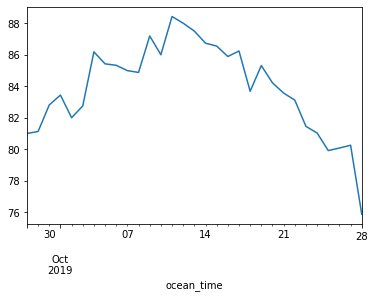

In [263]:
df['dist_mile'].plot()